# Clustering adverts as found on FB

In [1]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval
from llama_index.embeddings.openai import OpenAIEmbedding
from libraries.neo4j_lib import execute_neo4j_query
embed_model = OpenAIEmbedding(model="text-embedding-3-large")

## Load advert data

In [2]:
parameters = {}
query = """MATCH (n:Posting) WHERE (n.text IS NOT NULL) AND NOT (n.text = "") RETURN ID(n) AS IDn, n.text AS advert"""
postings = execute_neo4j_query(query, parameters)

## Calculate embeddings on post

In [ ]:
embeddings = []
for posting in postings:
    embed_model = OpenAIEmbedding(model="text-embedding-3-large")
    embedding = embed_model.get_text_embedding(posting["advert"])
    embeddings.append(embedding)
data = pd.DataFrame(postings)
data["embeddings"] = embeddings

## Save data

In [4]:
data.to_csv('data_sources/advert_embeddings.csv', index=False)

In [47]:
data = pd.read_csv('data_sources/advert_embeddings.csv')

In [48]:
def clean_embedding_string(embedding_str):
    # Remove surrounding brackets and any extra whitespace
    embedding_str = embedding_str.strip('[] ')
    # Split the string by commas and convert to list of floats
    return list(map(float, embedding_str.split(',')))

In [49]:
# Convert embeddings from string back to list of floats
data["embeddings"] = data["embeddings"].apply(clean_embedding_string)

In [50]:
data["embeddings"]

0      [-0.031837355345487595, 0.006913613062351942, ...
1      [-0.011502673849463463, -0.005082909483462572,...
2      [-0.023452598601579666, 0.009563448838889599, ...
3      [-0.0024959691800177097, -0.002152028726413846...
4      [-0.03960443660616875, -0.019802218303084373, ...
                             ...                        
156    [-0.04330151900649071, -0.01404567901045084, 0...
157    [-0.04590024799108505, -0.012707803398370743, ...
158    [-0.014115627855062485, -0.00788708496838808, ...
159    [-0.054574284702539444, -0.029944980517029762,...
160    [-0.0252003725618124, -0.028328893706202507, -...
Name: embeddings, Length: 161, dtype: object

In [51]:
matrix = np.vstack(data.embeddings.values)

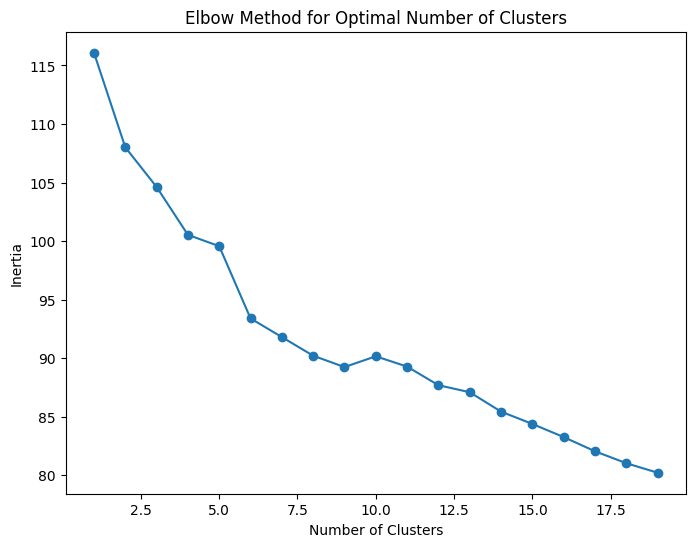

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate inertia for different numbers of clusters
inertia = []
k_values = range(1, 20)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    inertia.append(kmeans.inertia_)

# Plot the inertia values to visualize the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


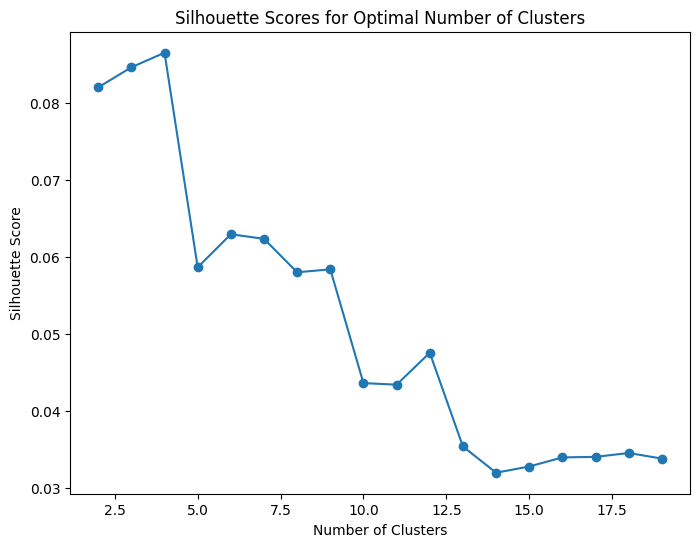

In [53]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
k_values = range(2, 20)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(matrix, labels))

# Plot the silhouette scores to visualize the best number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()


## Cluster adverts

In [54]:
from sklearn.cluster import KMeans

n_clusters = 14

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
data["Cluster"] = labels


## Plot results

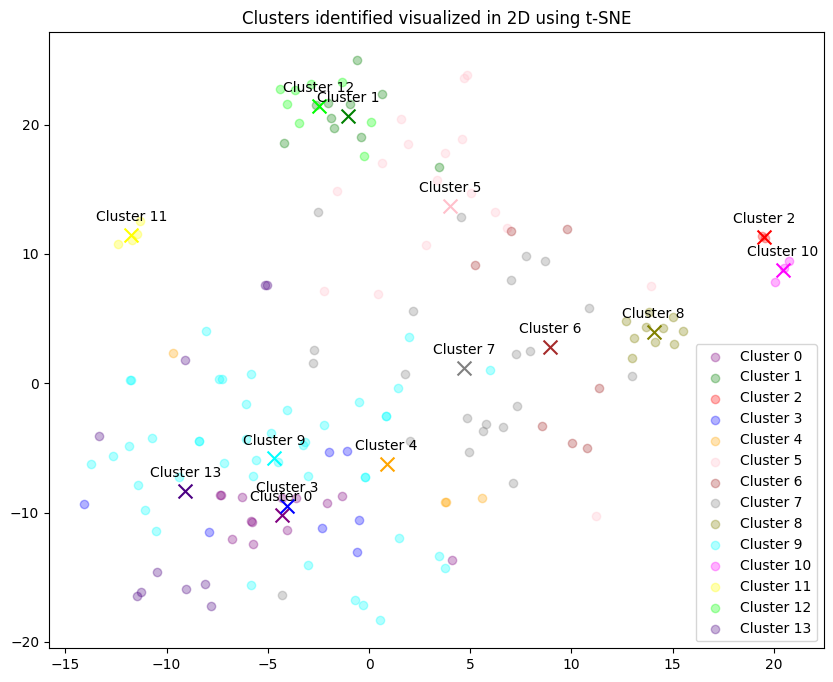

In [58]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `matrix` and `data` are already defined
n_clusters = 14

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
data["Cluster"] = labels

# t-SNE visualization
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# Define colors for each cluster
colors = [
    "purple", "green", "red", "blue", "orange", "pink", "brown",
    "gray", "olive", "cyan", "magenta", "yellow", "lime", "indigo"
]

# Plot each cluster
plt.figure(figsize=(10, 8))
for category, color in enumerate(colors):
    xs = np.array(x)[data.Cluster == category]
    ys = np.array(y)[data.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3, label=f'Cluster {category}')

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.annotate(f'Cluster {category}', (avg_x, avg_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='black')
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title("Clusters identified visualized in 2D using t-SNE")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

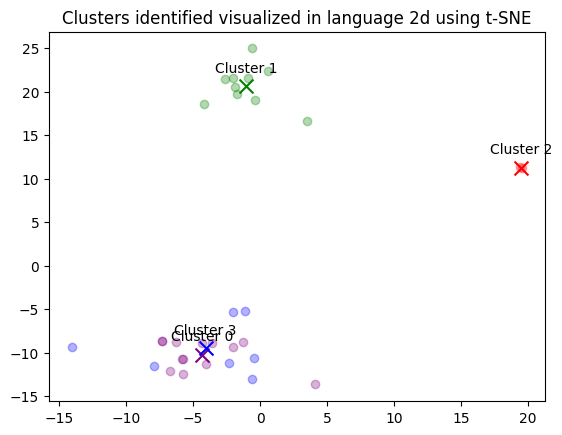

In [55]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[data.Cluster == category]
    ys = np.array(y)[data.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.annotate(f'Cluster {category}', (avg_x, avg_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='black')

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


## Results

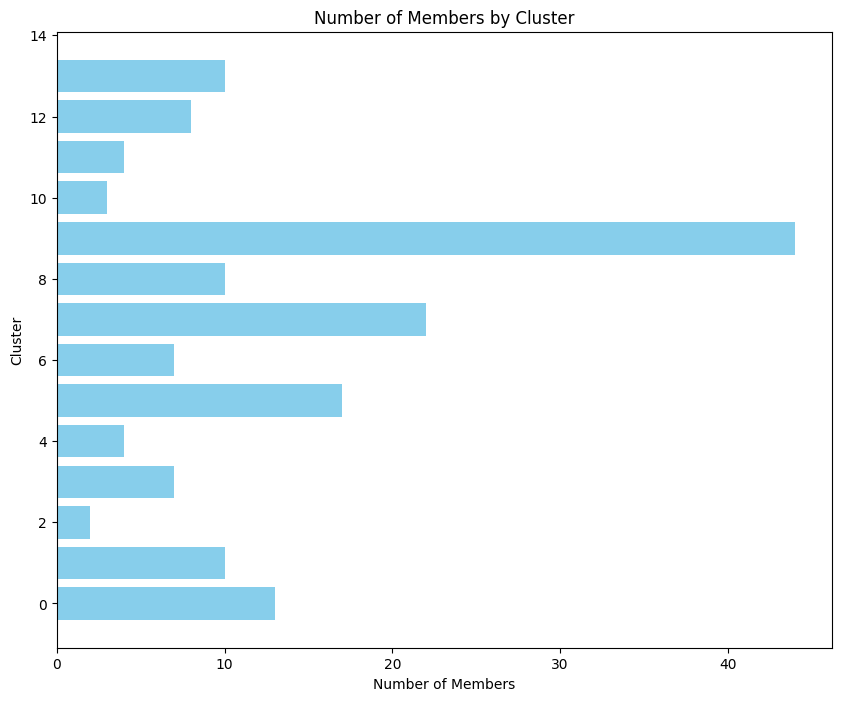

In [61]:
import matplotlib.pyplot as plt

# Calculate the number of members in each cluster
cluster_counts = data['Cluster'].value_counts().sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.xlabel('Number of Members')
plt.ylabel('Cluster')
plt.title('Number of Members by Cluster')
plt.show()

In [93]:
cluster_counts = data['Cluster'].value_counts().sort_values(ascending=False).copy()

In [94]:
cluster_counts

Cluster
9     44
7     22
5     17
0     13
8     10
13    10
1     10
12     8
3      7
6      7
11     4
4      4
10     3
2      2
Name: count, dtype: int64

In [98]:
df = pd.DataFrame(cluster_counts).rename(columns={'count':'number'}).copy()

In [99]:
df

,number
Cluster,
9,44
7,22
5,17
0,13
8,10
13,10
1,10
12,8
3,7


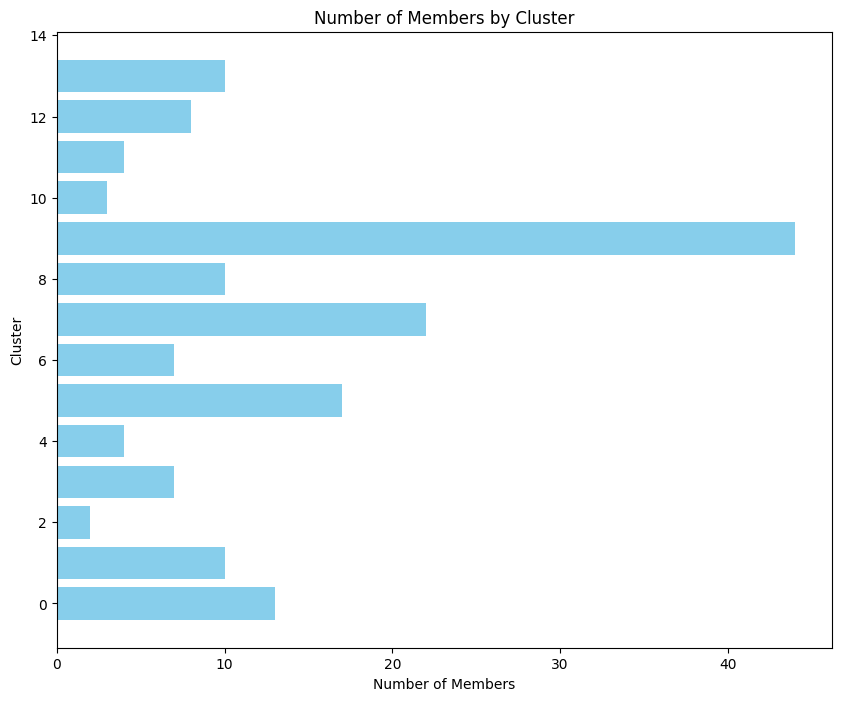

In [100]:
type(cluster_counts)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(df.index, df.number, color='skyblue')
plt.xlabel('Number of Members')
plt.ylabel('Cluster')
plt.title('Number of Members by Cluster')
plt.show()

In [57]:
from openai import OpenAI
import os
import pandas as pd

client = OpenAI()

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    cluster_data = data[data.Cluster == i]
    n_samples = min(rev_per_cluster, len(cluster_data))

    reviews = "\n".join(
        cluster_data.sample(n_samples, random_state=42)
        .apply(lambda x: str(x))
        .values
    )

    messages = [
        {
            "role": "user",
            "content": f'What do the following adverts have in common?\n\nAdverts:\n"""\n{reviews}\n"""\n\nTheme:',
        }
    ]

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=0,
        max_tokens=4096,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content.replace("\n", ""))

    sample_cluster_rows = cluster_data.sample(n_samples, random_state=42)
    for j in range(n_samples):
        print(sample_cluster_rows.IDn.values[j], end=":   ")
        print(sample_cluster_rows.advert.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme: The adverts listed share several commonalities that can help us identify a theme:1. **Job Type**: All the adverts are related to job postings for general workers or cleaning services.   - Examples:     - "EPWP: GENERAL WORKERS AND ROAD CLEANING SERVICES"     - "Servest Cleaning Jobs"     - "Unitrans hiring General Workers"     - "Rand Water Is Looking For General Workers"2. **Urgency and Call to Action**: Some adverts emphasize urgency and encourage immediate action.   - Examples:     - "Submit your CV today hurry"     - "Submit your CV today hurry"3. **Employer Names**: The adverts mention specific employers or organizations.   - Examples:     - "Servest"     - "Unitrans"     - "Rand Water"4. **Job Details**: Some adverts provide specific details about the job, such as the number of positions available or salary.   - Examples:     - "General Workers X 150"     - "Salary: R..."5. **Cluster**: All the adverts belong to the same cluster (Cluster 0), indicating that they 

In [ ]:
data.Cluster

In [28]:
matrix = np.vstack(data[data['Cluster']==0].embeddings.values)

In [30]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
data[data['Cluster']==0]["Cluster"] = labels


/var/folders/fj/0fc2zkjx0n1bf9w68cj96mww0000gn/T/ipykernel_39535/2830438209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['Cluster']==0]["Cluster"] = labels


/var/folders/fj/0fc2zkjx0n1bf9w68cj96mww0000gn/T/ipykernel_39535/2900715993.py:18: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/christostrydom/github_repos/lji_social_media/venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/fj/0fc2zkjx0n1bf9w68cj96mww0000gn/T/ipykernel_39535/2900715993.py:19: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

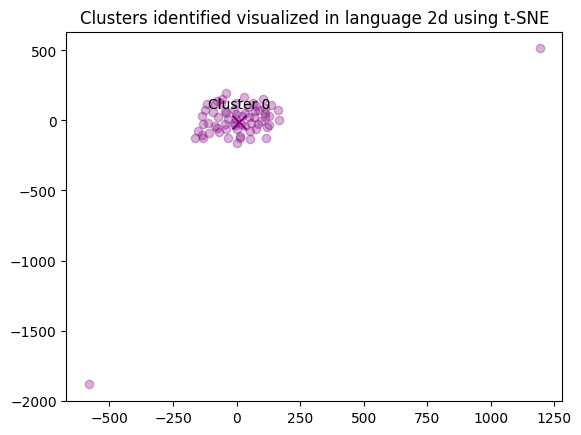

In [31]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[data[data['Cluster']==0].Cluster == category]
    ys = np.array(y)[data[data['Cluster']==0].Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.annotate(f'Cluster {category}', (avg_x, avg_y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='black')

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")